In [1]:
import pandas as pd
import numpy as np
import random
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline 

Using TensorFlow backend.


In [2]:
def getTrainData(img_size):
    img_dim = (img_size,img_size)

    train_csv = pd.read_csv('../train.csv')
    train_arr_imgs = [img_to_array(load_img('../train/'+img, target_size=img_dim)) for img in train_csv.image]
    x_train = np.array(train_arr_imgs)

    train_cat = train_csv['category'].values
    y_train = to_categorical(train_cat-1)

    return x_train, y_train

def getTestData(img_size):
    img_dim = (img_size,img_size)

    test_csv = pd.read_csv('../test.csv')
    #test_arr_imgs = [img_to_array(load_img('test/'+img, target_size=img_dim)) for img in test_csv.image]
    test_arr_imgs = []
    for img in test_csv.image:
        img_array = img_to_array(load_img('../test/'+img, target_size=img_dim))
        img_array = img_array/255.0
        test_arr_imgs.append(img_array)
    x_test = np.array(test_arr_imgs)

    test_cat = test_csv.category
    test_cv_y = test_cat-1
    y_test = np.array(test_cv_y)
    return x_test, y_test

In [3]:
def augData(x_train, y_train, batch_size):
    seed = 42
    random.seed = seed
    np.random.seed(seed=seed)
    train_datagen = ImageDataGenerator(rescale=1./255,  
                                       rotation_range=30,
                                       width_shift_range=0.15,
                                       height_shift_range=0.15,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=False,
                                       fill_mode='nearest')
    train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size, seed=seed)
    return train_generator

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNet

IMG_SHAPE = (200, 200, 3)

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
base_model.trainable = False

model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(1024,activation='relu'),
  #Dropout(rate=0.5),
  Dense(512,activation='relu'),
  #Dropout(rate=0.5),
  Dense(5, activation='softmax')
])
model.summary()

C:\Users\8FTMA26199\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 6, 6, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 4,805,829
Trainable params: 1,576,965
Non-trainable params: 3,228,864
_________________________________________________________________


In [5]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [6]:
batch_size = 32
x_train, y_train = getTrainData(200)
train_generator = augData(x_train, y_train, batch_size)

In [7]:
import time
startTime = time.time()

history = model.fit_generator(train_generator,
                              steps_per_epoch=len(x_train) // batch_size,
                              epochs=10)
endTime = time.time()

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 78 steps
Epoch 1/10
78/78 [==============================] - 99s 1s/step - loss: 0.7109 - accuracy: 0.7808
Epoch 2/10
78/78 [==============================] - 94s 1s/step - loss: 0.2055 - accuracy: 0.9323
Epoch 3/10
78/78 [==============================] - 99s 1s/step - loss: 0.2334 - accuracy: 0.9218
Epoch 4/10
78/78 [==============================] - 96s 1s/step - loss: 0.1613 - accuracy: 0.9461
Epoch 5/10
78/78 [==============================] - 96s 1s/step - loss: 0.1772 - accuracy: 0.9437
Epoch 6/10
78/78 [==============================] - 95s 1s/step - loss: 0.1257 - accuracy: 0.9566
Epoch 7/10
78/78 [==============================] - 91s 1s/step - loss: 0.1358 - accuracy: 0.9514
Epoch 8/10
78/78 [==============================] - 95s 1s/step - loss: 0.1360 - accuracy: 0.9546
Epoch 9/10
78/78 [==============================] - 100s 1s/step - loss: 0.1772 - accuracy: 0.94

In [8]:
name = 'MobileNet_R8-e10_NoDropout'
model_name = 'Mobile Net'

In [9]:
def saveH5(model,name):
    model.save_weights(name+'_model-save-wieghts.h5')
    model.save(name+'_model-save.h5')
saveH5(model,name)

In [10]:
def saveHistory(history, name):
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)
    hist_csv_file = name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
saveHistory(history,name)

In [11]:
def printTime(startTime, endTime):
    print("Strat time = "+str(startTime))
    print("End time = "+str(endTime))
    print("Use time = "+str(endTime-startTime))
printTime(startTime, endTime)

Strat time = 1588220645.4900868
End time = 1588221613.976859
Use time = 968.4867722988129


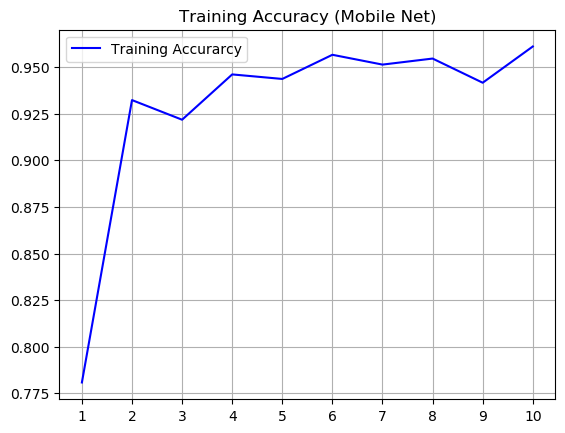

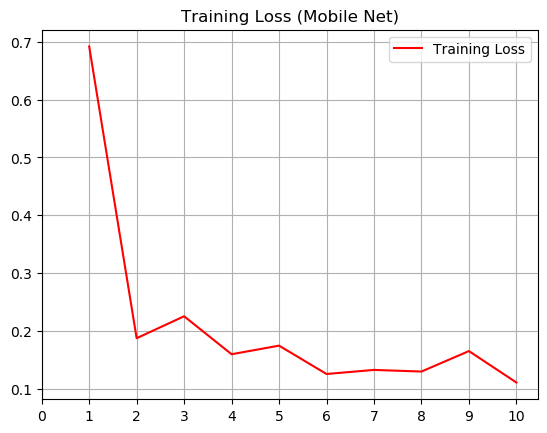

In [12]:
def plotAccuracyLoss(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)

    #Train and validation accuracy
    plt.style.use('default')
    plt.grid(True)
    plt.xticks(np.arange(0, len(acc)+1, 1.0))
    #plt.yticks(np.arange(0, 1))
    plt.plot(epochs, acc, 'b', label='Training Accurarcy')
    plt.title('Training Accuracy ('+model_name+')')
    plt.legend()
    plt.grid(True)
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.grid(True)
    plt.xticks(np.arange(0, len(acc)+1, 1.0))
    plt.title('Training Loss ('+model_name+')')
    plt.legend()
    plt.show()
plotAccuracyLoss(history)

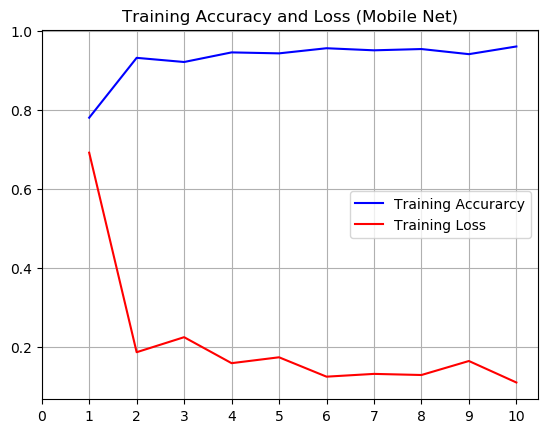

In [13]:
def plotBothAccuracyLoss(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)

    #Train and validation accuracy
    plt.style.use('default')
    plt.grid(True)
    plt.xticks(np.arange(0, len(acc)+1, 1.0))
    #plt.yticks(np.arange(0, 1))
    plt.plot(epochs, acc, 'b', label='Training Accurarcy')
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.grid(True)
    plt.xticks(np.arange(0, len(acc)+1, 1.0))
    plt.title('Training Accuracy and Loss ('+model_name+')')
    plt.legend()
    plt.show()
plotBothAccuracyLoss(history)

In [14]:
x_test, y_test = getTestData(200)

In [15]:
y_pred = model.predict(x_test)

In [16]:
def convertPred1D(y_pred):
    get_argmax = []
    for i in range(len(y_pred)):
        get_argmax.append(np.argmax(y_pred[i]))
    return get_argmax
y_pred1d = convertPred1D(y_pred)

In [17]:
def savePrediction(pred, name):
    test_csv = pd.read_csv('../test.csv')
    test_dict = {'image': test_csv.image, 'y_true': test_csv.category-1, 'y_pred': pred}
    df_pred = pd.DataFrame(test_dict)
    export_pred = df_pred.to_csv(r''+name+'_y-prediction.csv', index = None, header=True)
savePrediction(y_pred1d, name)

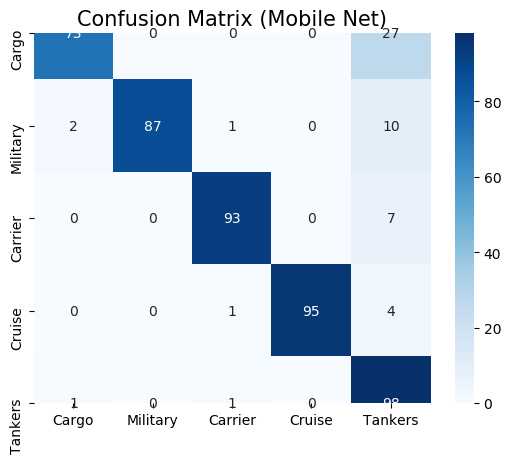

In [18]:
def plotConfusionMatrix(array, name):
    df_cm = pd.DataFrame(array, index = ['Cargo', 'Military', 'Carrier', 'Cruise', 'Tankers'], columns = ['Cargo', 'Military', 'Carrier', 'Cruise', 'Tankers'])
    plt.figure()
    sn.heatmap(df_cm, annot=True, cmap="Blues")
    plt.title('Confusion Matrix ('+name+')',fontsize = 15)
    plt.show()
plotConfusionMatrix(confusion_matrix(y_test, y_pred1d),model_name)

In [19]:
confusion_matrix(y_test, y_pred1d)

array([[73,  0,  0,  0, 27],
       [ 2, 87,  1,  0, 10],
       [ 0,  0, 93,  0,  7],
       [ 0,  0,  1, 95,  4],
       [ 1,  0,  1,  0, 98]], dtype=int64)

In [20]:
def printReport(y_test, y_pred, name):
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    df_rp = pd.DataFrame(report).transpose()
    export_rp = df_rp.to_csv(r''+name+'_cls-report.csv', index = None, header=True)
printReport(y_test, y_pred1d, name)

              precision    recall  f1-score   support

           0       0.96      0.73      0.83       100
           1       1.00      0.87      0.93       100
           2       0.97      0.93      0.95       100
           3       1.00      0.95      0.97       100
           4       0.67      0.98      0.80       100

    accuracy                           0.89       500
   macro avg       0.92      0.89      0.90       500
weighted avg       0.92      0.89      0.90       500

